## Final Model

In [3]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('data/features.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True) 

In [5]:
df.head()

,state,number,year,population,renter_occupied_households,eviction_filings,evictions,total_ssi,aged_ssi,disbl_ssi,...,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,homeless_count,smha_per_cap,total_smha
0,alabama,AL-500,2007,845208,104742,3203,656,25480,1839,23641,...,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2104,74.03,62570748.24
1,alabama,AL-500,2008,845208,105612,2172,976,25762,1722,24040,...,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2104,79.39,67101063.12
2,alabama,AL-500,2009,845208,106482,1785,945,26244,1615,24629,...,25.15,3.43,0.20,1.44,0.03,0.77,0.12,2273,77.89,65833251.12
3,alabama,AL-500,2010,853551,107353,2486,1605,27098,1525,25573,...,26.20,4.90,0.22,1.64,0.02,0.99,0.10,2273,78.19,66739152.69
4,alabama,AL-500,2011,862556,108846,3708,2257,27532,1459,26073,...,26.95,4.82,0.23,1.80,0.02,1.10,0.16,1950,78.33,67564011.48


In [6]:
df.shape

(3157, 33)

In [7]:
# encode the state and coc-numbers

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(df.state)
df['state_code'] = label_encoder.transform(df.state)

label_encoder.fit(df.number)
df['coc'] = label_encoder.transform(df.number)

df.drop(['state','number'],axis=1,inplace=True)

In [9]:
#train-test-split

In [10]:
target = df['homeless_count']
features = df.drop('homeless_count', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)

In [11]:
#Grid Search
parameters={'max_depth': (14, 20, 2),'n_estimators': [100,500,1000],
            'min_samples_split': (2,11,2), 'max_samples':[.3,.5],
            'criterion': ['mse']}

rf_reg = RandomForestRegressor(random_state = 42)
grid_forest = GridSearchCV(rf_reg, parameters, cv=5)

In [12]:
grid_forest = grid_forest.fit(X_train, y_train)
print(grid_forest.best_score_)
print(grid_forest.best_params_)
print(grid_forest.best_estimator_)

0.8953457501979312
{'criterion': 'mse', 'max_depth': 14, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 1000}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [13]:
y_pred = grid_forest.best_estimator_.predict(X_test)
print("r2_score:",metrics.r2_score(y_test, y_pred))
print("MSE:",metrics.mean_squared_error(y_test, y_pred))
print("MAE:",metrics.mean_absolute_error(y_test, y_pred))

r2_score: 0.9405724936737201
MSE: 396580.5163363079
MAE: 300.7510859936927


In [14]:
r_forest = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)
r_forest.fit(X_train, y_train)
predict_test = r_forest.predict(X_test)
print("r2_score:", metrics.r2_score(y_test,predict_test))
print("oob score:",r_forest.oob_score_)
print("MSE score:",metrics.mean_squared_error(y_test, predict_test))
print("MAE score:",metrics.mean_absolute_error(y_test, predict_test))

r2_score: 0.9405724936737201
oob score: 0.9253879938402909
MSE score: 396580.5163363079
MAE score: 300.7510859936927


In [15]:
#explore feature importances

In [16]:
feature_importances = pd.DataFrame(r_forest.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

In [17]:
feature_importances[0:10]

,importance
renter_occupied_households,0.231645
aged_ssi,0.191386
pct_nh_pi,0.095928
65_ovr_ssi,0.077287
pct_white,0.071346
pct_renter_occupied,0.031773
total_ssi,0.027573
disbl_ssi,0.024432
18_und_ssi,0.019067
pct_af_am,0.017726


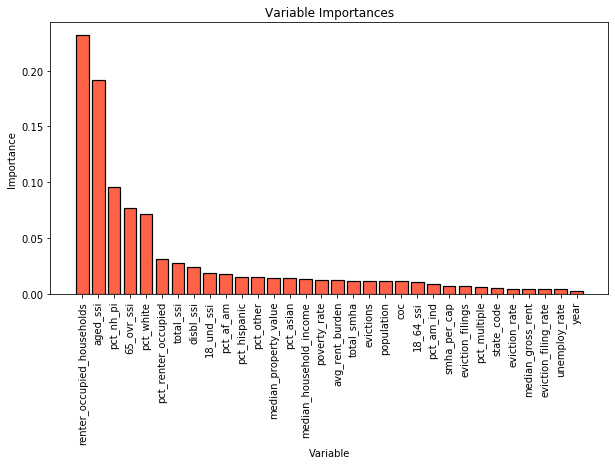

In [18]:
# list of x locations for plotting
x_values = list(range(len(feature_importances)))
# Make a bar chart
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x_values, feature_importances.importance, orientation = 'vertical', color = 'tomato', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_importances.index, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [19]:
cumulative_importances = np.cumsum(feature_importances.importance)

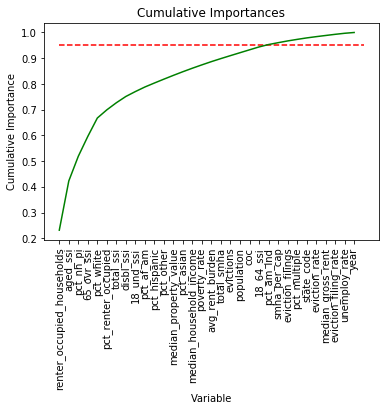

In [20]:
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(feature_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_importances.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');


In [21]:
# Find number of features for cumulative importance of 95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 23


In [22]:
feature_importances.reset_index(inplace=True)

In [23]:
feature_importances.rename({'index': 'feature'}, axis=1, inplace=True)
feature_list = list(features.columns)

In [24]:
# Extract the names of the most important features
important_feature_names = [feature for feature in feature_importances.feature[0:23]]

In [25]:
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (2525, 23)
Important test features shape: (632, 23)


In [32]:
# Grid Search with top 95% features

In [ ]:
# Model with most impactful features

In [35]:
ran_forest = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
ran_forest.fit(important_train_features, y_train)
predict_ = ran_forest.predict(important_test_features)
print("r2_score:", metrics.r2_score(y_test,predict_))
print("oob score:",ran_forest.oob_score_)
print("MSE score:",metrics.mean_squared_error(y_test, predict_))
print("MAE score:",metrics.mean_absolute_error(y_test, predict_))

r2_score: 0.9443576928202196
oob score: 0.9278691994129691
MSE score: 371320.5597143228
MAE score: 288.23230959381715


In [37]:
top_features = pd.DataFrame(ran_forest.feature_importances_, index = important_test_features.columns, columns=['importance']).sort_values('importance',ascending=False)

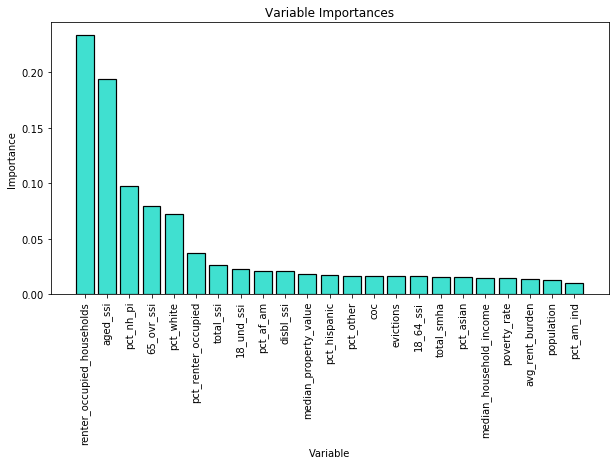

In [40]:
# list of x locations for plotting
x_values = list(range(len(top_features)))
# Make a bar chart
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x_values, top_features.importance, orientation = 'vertical', color = 'turquoise', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, top_features.index, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');